# Data Exploration

In [23]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

## Loading Data

In [2]:
#Read files:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [3]:
#Combine test and train into one file
train['source']='train'
test['source']='test'
data = pd.concat([train, test], ignore_index=True)
print (train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [4]:
#Check missing values:
data.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

In [5]:
#Numerical data summary:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [6]:
#Number of unique values in each:
data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [7]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of Categories for varible %s'%col)
    print (data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

# Data Cleaning

## Imputating Item_Weight Missing Values

In [8]:
#Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')
item_avg_weight.head()

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115


In [9]:
#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.loc[x])
print ('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


## Imputing Outlet_Size Missing Values

In [10]:
#Import mode function:
from scipy.stats import mode

outlet_size_mode = data.dropna(subset=['Outlet_Size']).pivot_table(values='Outlet_Size', columns='Outlet_Type',
                                                aggfunc=(lambda x:mode(x.astype(str)).mode[0]), dropna=True).unstack()

print ('Mode for each Outlet_Type:')
print (outlet_size_mode)

#Get a boolean variable specifying missing Outlet_Size values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print (sum(data['Outlet_Size'].isnull()))

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


Mode for each Outlet_Type:
Outlet_Type                   
Grocery Store      Outlet_Size     Small
Supermarket Type1  Outlet_Size     Small
Supermarket Type2  Outlet_Size    Medium
Supermarket Type3  Outlet_Size    Medium
dtype: object

Orignal #missing: 4016
0


# Feature Engineering

## Step1: Consider combining categories in Outlet_Type

In [11]:
#Check the mean sales by type:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


## Step2: Modify Item_Visibility

In [12]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.loc[x])
print ('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [13]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg.loc[x['Item_Identifier']], axis=1)
print (data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


## Step 3: Create a broad category of Type of Item

In [14]:
#Item type combine:
data['Item_Identifier'].value_counts()
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

## Step 4: Determine the years of operation of a store

In [15]:
#Years:
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

## Step 5: Modify categories of Item_Fat_Content

In [16]:
#Change categories of low fat:
print ('Original Categories:')
print (data['Item_Fat_Content'].value_counts())

print ('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print (data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [17]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

## Step 6: Numerical and One-Hot Coding of Categorical variables

In [18]:
#Import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [19]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [20]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
O

In [21]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


## Step7: Exporting Data

In [22]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("datasets/train_modified.csv",index=False)
test.to_csv("datasets/test_modified.csv",index=False)

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Model Building

## Load Data

In [25]:
train = pd.read_csv("datasets/train_modified.csv")
test = pd.read_csv("datasets/test_modified.csv")

In [27]:
print (train.shape)
train.dtypes

(8523, 34)


Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Visibility              float64
Item_Weight                  float64
Outlet_Identifier             object
Item_Visibility_MeanRatio    float64
Outlet_Years                   int64
Item_Fat_Content_0             int64
Item_Fat_Content_1             int64
Item_Fat_Content_2             int64
Outlet_Location_Type_0         int64
Outlet_Location_Type_1         int64
Outlet_Location_Type_2         int64
Outlet_Size_0                  int64
Outlet_Size_1                  int64
Outlet_Size_2                  int64
Outlet_Type_0                  int64
Outlet_Type_1                  int64
Outlet_Type_2                  int64
Outlet_Type_3                  int64
Item_Type_Combined_0           int64
Item_Type_Combined_1           int64
Item_Type_Combined_2           int64
Outlet_0                       int64
Outlet_1                       int64
Outlet_2                       int64
O

## Creating Baseline Model

In [28]:
#Mean based:
mean_sales = train['Item_Outlet_Sales'].mean()

#Define a dataframe with IDs for submission:
base1 = test[['Item_Identifier','Outlet_Identifier']]
base1['Item_Outlet_Sales'] = mean_sales

#Export submission file
base1.to_csv("datasets/alg0.csv",index=False)

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Function to Fit and Generate Submission File

In [30]:
#Define target and ID columns:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn import cross_validation, metrics
def modelfit(alg, dtrain, dtest, predictors, target, IDcol, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])

    #Perform cross-validation:
    cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain[target], cv=20, scoring='mean_squared_error')
    cv_score = np.sqrt(np.abs(cv_score))
    
    #Print model report:
    print ("\nModel Report")
    print ("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values, dtrain_predictions)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    dtest[target] = alg.predict(dtest[predictors])
    
    #Export submission file:
    IDcol.append(target)
    submission = pd.DataFrame({ x: dtest[x] for x in IDcol})
    submission.to_csv("datasets/" + filename, index=False)

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Linear Regression Model

In [31]:
from sklearn.linear_model import LinearRegression, Ridge

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.


Model Report
RMSE : 1128
CV Score : Mean - 1129 | Std - 44.05 | Min - 1075 | Max - 1215


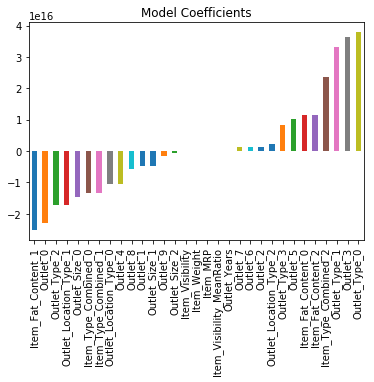

In [32]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

## Ridge Regression Model

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.


Model Report
RMSE : 1129
CV Score : Mean - 1130 | Std - 44.6 | Min - 1076 | Max - 1217


/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.

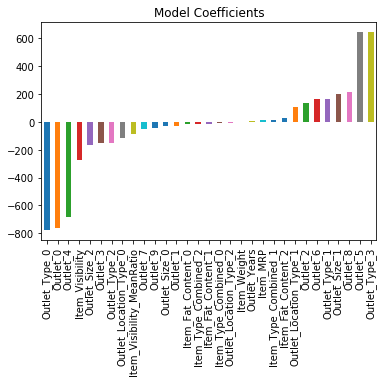

In [33]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

## Decision Tree Model

In [34]:
from sklearn.tree import DecisionTreeRegressor

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.


Model Report
RMSE : 1058
CV Score : Mean - 1091 | Std - 45.42 | Min - 1003 | Max - 1186


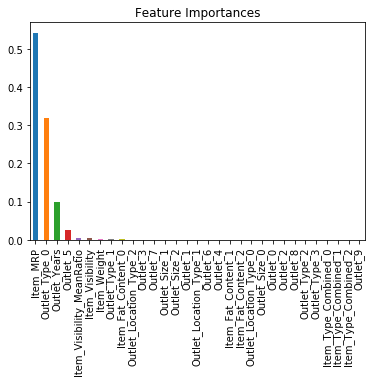

In [35]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.


Model Report
RMSE : 1071
CV Score : Mean - 1096 | Std - 43.3 | Min - 1027 | Max - 1172


/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


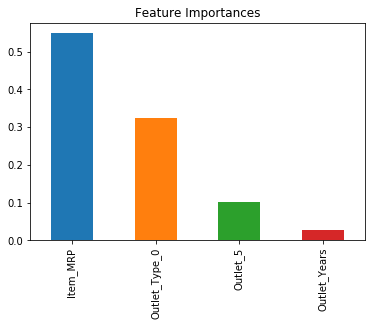

In [36]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Years']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

## Random Forest Model

In [37]:
from sklearn.ensemble import RandomForestRegressor

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.


Model Report
RMSE : 1073
CV Score : Mean - 1084 | Std - 43.56 | Min - 1022 | Max - 1162


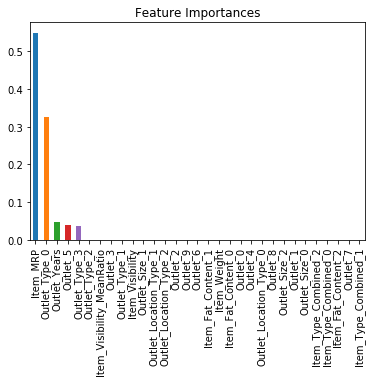

In [38]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')

/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/dorondusheiko/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.


Model Report
RMSE : 1068
CV Score : Mean - 1083 | Std - 43.78 | Min - 1019 | Max - 1161


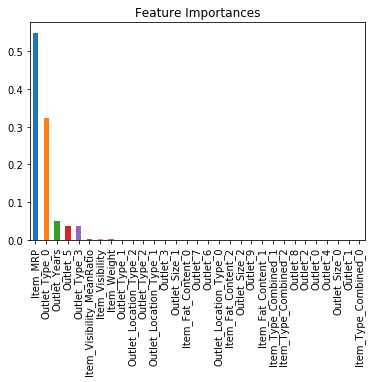

In [39]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg6 = RandomForestRegressor(n_estimators=400,max_depth=6, min_samples_leaf=100,n_jobs=4)
modelfit(alg6, train, test, predictors, target, IDcol, 'alg6.csv')
coef6 = pd.Series(alg6.feature_importances_, predictors).sort_values(ascending=False)
coef6.plot(kind='bar', title='Feature Importances')